In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [2]:
# Check if CUDA is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")
    print(f"GPU name: {torch.cuda.get_device_name(1)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(1).total_memory / 1e9} GB")

CUDA available: True
GPU name: Tesla T4
GPU memory: 15.828320256 GB
GPU name: Tesla T4
GPU memory: 15.828320256 GB


In [3]:
df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')

# Separate labels and pixel data
labels = df['label'].values  # If you want labels later
images = df.drop('label', axis=1).values  # Drop 'label' column

# Normalize pixel values from [0,255] -> [0,1]
images = images / 255.0

# Convert to torch tensors
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Reshape to (N, 1, 28, 28)
images = images.view(-1, 1, 28, 28)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: torch.Size([60000, 1, 28, 28])
Labels shape: torch.Size([60000])


In [26]:
import torch
import torch.nn as nn
import math

# Sinusoidal positional embedding
def get_timestep_embedding(timesteps, dim):
    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half, dtype=torch.float32) / half
    ).to(timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    return emb  # shape: [batch_size, dim]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_proj = nn.Linear(time_emb_dim, out_channels)

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.relu2 = nn.ReLU()

        self.residual = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity()
        )

    def forward(self, x, t_emb):
        time_emb = self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]

        out = self.conv1(x)
        out = out + time_emb
        out = self.norm1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu2(out)

        return out + self.residual(x)

class SimpleUNet(nn.Module):
    def __init__(self, time_emb_dim=256):
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.time_proj = nn.Linear(1, time_emb_dim)  # or adjust input dim accordingly


        # Encoder
        self.conv1 = ResidualBlock(1, 64, time_emb_dim)
        self.down1 = nn.Conv2d(64, 64, 4, 2, 1)

        self.conv2 = ResidualBlock(64, 128, time_emb_dim)
        self.down2 = nn.Conv2d(128, 128, 4, 2, 1)

        self.conv3 = ResidualBlock(128, 256, time_emb_dim)

        # Bottleneck
        self.bottleneck = ResidualBlock(256, 256, time_emb_dim)

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.conv_up1 = ResidualBlock(256, 128, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.conv_up2 = ResidualBlock(128, 64, time_emb_dim)

        # Output
        self.out_conv = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)  # [B, time_emb_dim]
    
        # Encoder
        x1 = self.conv1(x, t_emb)
        x2 = self.conv2(self.down1(x1), t_emb)
        x3 = self.conv3(self.down2(x2), t_emb)
    
        # Bottleneck
        x4 = self.bottleneck(x3, t_emb)
    
        # Decoder
        x5 = self.conv_up1(torch.cat([self.up1(x4), x2], dim=1), t_emb)
        x6 = self.conv_up2(torch.cat([self.up2(x5), x1], dim=1), t_emb)
    
        return self.out_conv(x6)







# Noise schedule (simple linear beta)
def get_noise_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

# Cosine beta schedule
def cosine_beta_schedule(T, s=0.008):
    steps = T + 1
    x = np.linspace(0, T, steps)
    alphas_cumprod = np.cos(((x / T) + s) / (1 + s) * np.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = np.clip(betas, a_min=0, a_max=0.999)
    return torch.tensor(betas, dtype=torch.float32)

# Add noise to data
def add_noise(x0, t, alphas_cumprod):
    """
    x0: original clean image [batch_size, C, H, W]
    t: timestep tensor [batch_size] (integer steps)
    alphas_cumprod: precomputed alpha cumulative products [T]
    """
    noise = torch.randn_like(x0)
    batch_size = x0.size(0)

    sqrt_alpha_cumprod = torch.sqrt(alphas_cumprod[t]).view(batch_size, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alphas_cumprod[t]).view(batch_size, 1, 1, 1)

    x_t = sqrt_alpha_cumprod * x0 + sqrt_one_minus_alpha_cumprod * noise
    return x_t, noise

def get_index_from_list(vals, t, x_shape):
    """
    vals: 1D tensor of size [T]
    t: [batch_size]
    x_shape: shape to reshape for broadcasting
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t).float()
    return out.view(batch_size, *((1,) * (len(x_shape) - 1)))

def q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    return (
        get_index_from_list(sqrt_alphas_cumprod, t, x_start.shape) * x_start +
        get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
    ), noise

def p_sample(model, x, t, betas):
    beta_t = betas[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - torch.cumprod(1 - betas, dim=0)[t]).view(-1, 1, 1, 1)
    sqrt_recip_alpha = torch.sqrt(1 / (1 - beta_t))

    # Predict the noise
    noise_pred = model(x, t.float() / len(betas))

    # Compute the mean of the posterior q(x_{t-1} | x_t, x_0)
    x0_pred = (x - sqrt_one_minus_alpha_bar * noise_pred) / torch.sqrt(torch.cumprod(1 - betas, dim=0)[t]).view(-1, 1, 1, 1)
    mean = torch.sqrt(1 - beta_t) * x0_pred + beta_t * torch.randn_like(x)

    return mean

def p_sample_loop(model, x_t, t, betas):
    """
    Run the reverse diffusion process from timestep t to 0.
    """
    x = x_t
    for current_t in reversed(range(0, t.min().item() + 1)):
        t_batch = torch.full((x.size(0),), current_t, device=x.device, dtype=torch.long)
        x = p_sample(model, x, t_batch, betas)
    return x

    
def train_step(model, x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, optimizer):
    model.train()
    x_noisy, noise = q_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    noise_pred = model(x_noisy, t.float() / T)  # Normalize t to [0, 1]
    loss = F.mse_loss(noise_pred, noise)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def sample_ddpm(model, image_size, betas, n_steps, device):
    model.eval()
    T = len(betas)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
    alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), alphas_cumprod[:-1]])

    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    img = torch.randn(1, 1, image_size, image_size).to(device)

    for t in reversed(range(T)):
        time = torch.full((1,), t, device=device, dtype=torch.long)
        beta_t = betas[t]
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alphas_cumprod[t])
        sqrt_recip_alpha_t = sqrt_recip_alphas[t]
        
        model_mean = sqrt_recip_alpha_t * (img - beta_t / sqrt_one_minus_alpha_cumprod_t * model(img, time.float() / T))

        if t > 0:
            noise = torch.randn_like(img)
            sigma_t = torch.sqrt(posterior_variance[t])
            img = model_mean + sigma_t * noise
        else:
            img = model_mean
    return img


In [27]:
class ImprovedRefinementNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input is the denoised image
        # Adding skip connections to preserve spatial information
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder with skip connections
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 128, 64, 3, padding=1),  # +128 for skip connection
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.dec1 = nn.Sequential(
            nn.Conv2d(64 + 64, 32, 3, padding=1),  # +64 for skip connection
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Encoding
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        
        # Decoding with skip connections
        d3 = self.dec3(e3)
        d2 = self.dec2(torch.cat([d3, e2], dim=1))
        d1 = self.dec1(torch.cat([d2, e1], dim=1))
        
        # Final output
        output = self.final(d1)
        
        return output

In [28]:
T = 1000
model = SimpleUNet()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
betas = cosine_beta_schedule(T).to(device)

# Create Dataset
dataset = TensorDataset(images, labels)

# Split dataset into training and validation (80/20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create and train the improved refinement network
refine_model = ImprovedRefinementNetwork()
refine_optimizer = optim.Adam(refine_model.parameters(), lr=0.0005)
refine_scheduler = optim.lr_scheduler.ReduceLROnPlateau(refine_optimizer, 'min', patience=5, factor=0.5)
refine_criterion = nn.MSELoss()

# Enable multi-GPU training if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training!")
    model = nn.DataParallel(model)
    refine_model = nn.DataParallel(refine_model)

# Move models to device
model = model.to(device)
refine_model = refine_model.to(device)

# Adjust batch size to take advantage of multiple GPUs
original_batch_size = 128
batch_size = original_batch_size * torch.cuda.device_count() if torch.cuda.device_count() > 1 else original_batch_size
print(f"Updated batch size: {batch_size}")

# Create separate DataLoaders for training and validation
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True, 
    num_workers=4
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No need to shuffle validation data
    pin_memory=True, 
    num_workers=4
)

print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")

# Optional: Set a fixed seed for reproducible splits
# torch.manual_seed(42)  # Uncomment this line for reproducible splits

Training samples: 48000
Validation samples: 12000
Using 2 GPUs for training!
Updated batch size: 256
Training batches: 188
Validation batches: 47


Epoch 1/100: 100%|██████████| 188/188 [00:20<00:00,  9.03it/s, loss=0.0704]


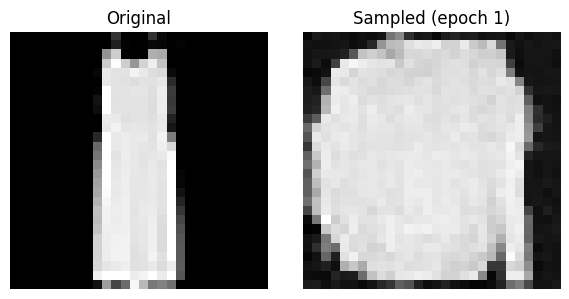

Epoch 6/100: 100%|██████████| 188/188 [00:20<00:00,  9.07it/s, loss=0.0481]


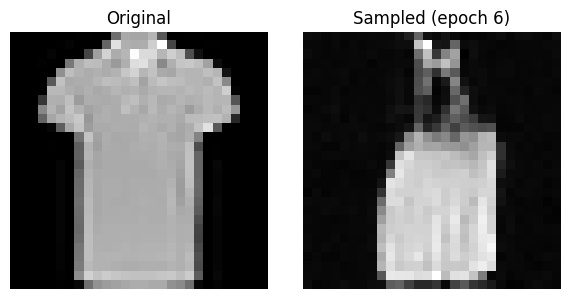

Epoch 11/100: 100%|██████████| 188/188 [00:20<00:00,  9.04it/s, loss=0.0507]


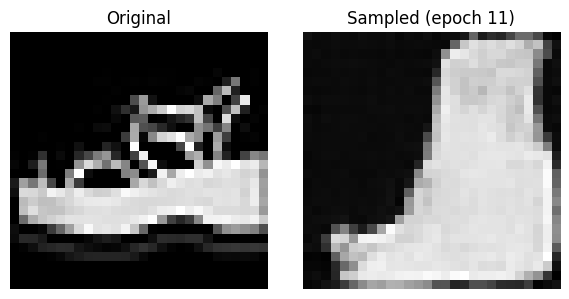

Epoch 16/100: 100%|██████████| 188/188 [00:20<00:00,  9.05it/s, loss=0.0694]


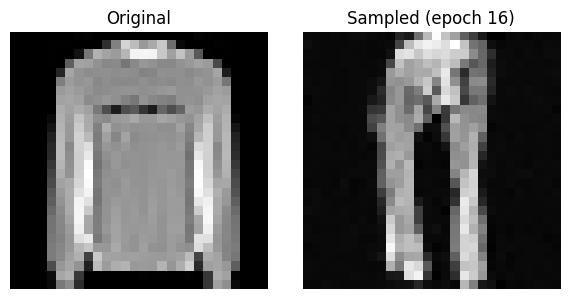

Epoch 21/100: 100%|██████████| 188/188 [00:20<00:00,  9.03it/s, loss=0.0468]


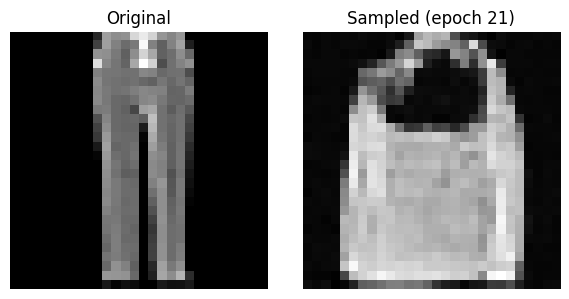

Epoch 26/100: 100%|██████████| 188/188 [00:20<00:00,  9.06it/s, loss=0.0417]


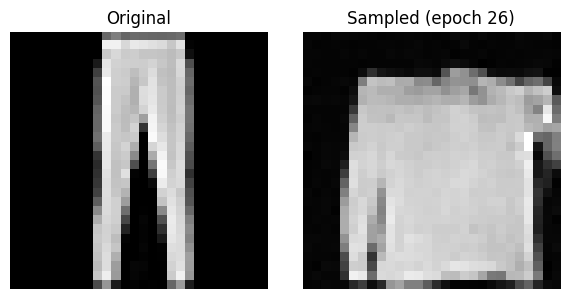

Epoch 31/100: 100%|██████████| 188/188 [00:20<00:00,  9.00it/s, loss=0.0498]


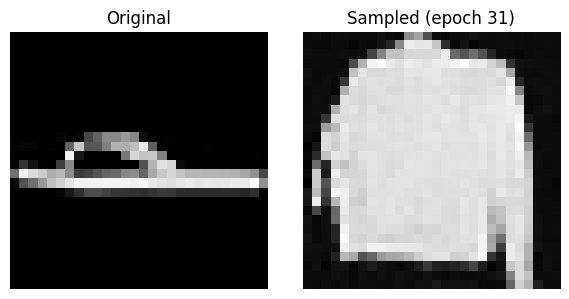

Epoch 36/100: 100%|██████████| 188/188 [00:20<00:00,  9.01it/s, loss=0.0488]


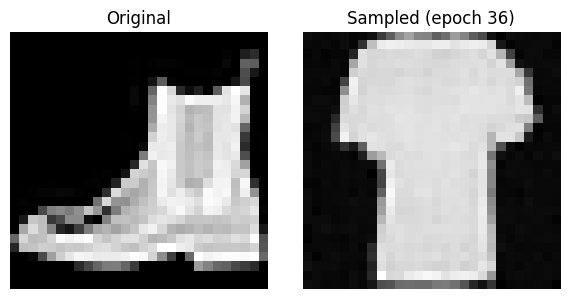

Epoch 41/100: 100%|██████████| 188/188 [00:20<00:00,  9.02it/s, loss=0.0424]


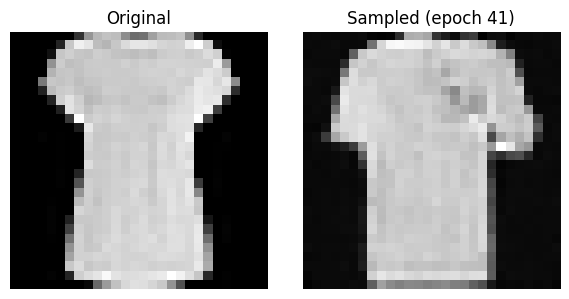

Epoch 46/100: 100%|██████████| 188/188 [00:20<00:00,  9.06it/s, loss=0.0448]


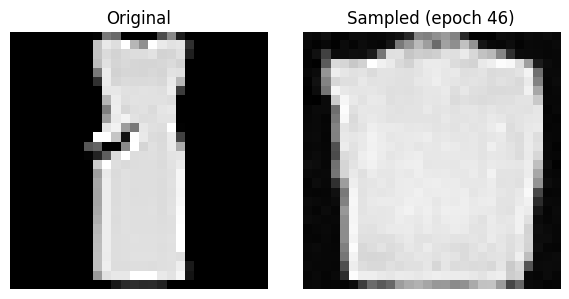

Epoch 51/100: 100%|██████████| 188/188 [00:20<00:00,  9.05it/s, loss=0.0471]


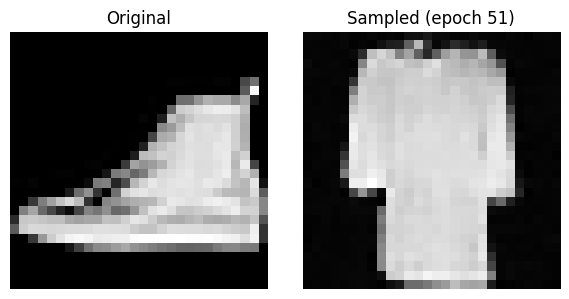

Epoch 56/100: 100%|██████████| 188/188 [00:20<00:00,  9.01it/s, loss=0.0422]


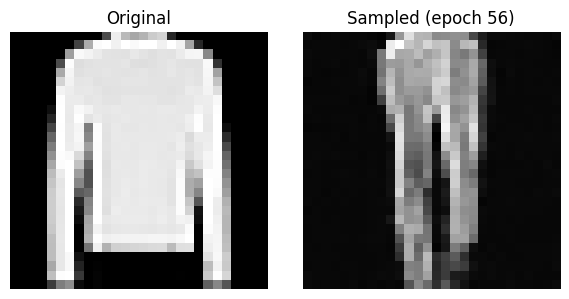

Epoch 61/100: 100%|██████████| 188/188 [00:20<00:00,  9.05it/s, loss=0.047] 


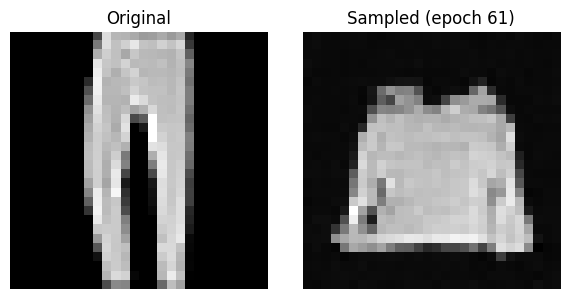

Epoch 66/100: 100%|██████████| 188/188 [00:20<00:00,  9.07it/s, loss=0.0353]


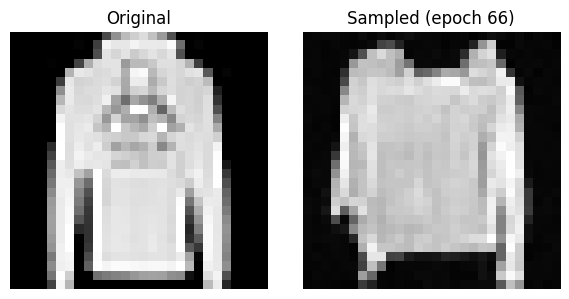

Epoch 71/100: 100%|██████████| 188/188 [00:20<00:00,  9.04it/s, loss=0.0465]


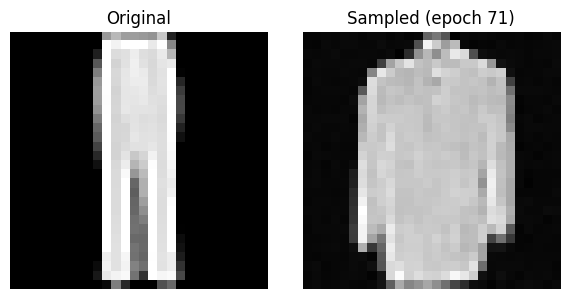

Epoch 76/100: 100%|██████████| 188/188 [00:20<00:00,  9.03it/s, loss=0.0457]


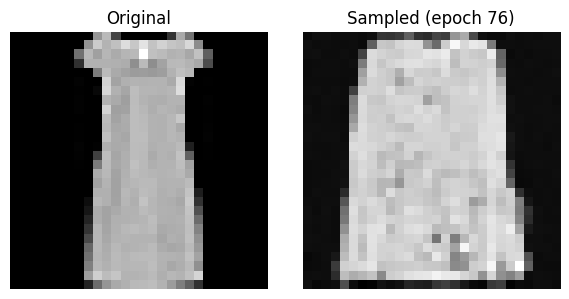

Epoch 81/100: 100%|██████████| 188/188 [00:20<00:00,  9.04it/s, loss=0.0398]


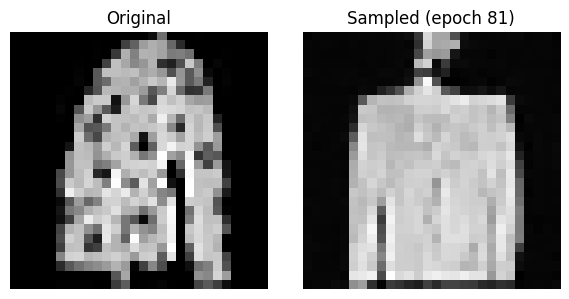

Epoch 86/100: 100%|██████████| 188/188 [00:20<00:00,  9.05it/s, loss=0.0559]


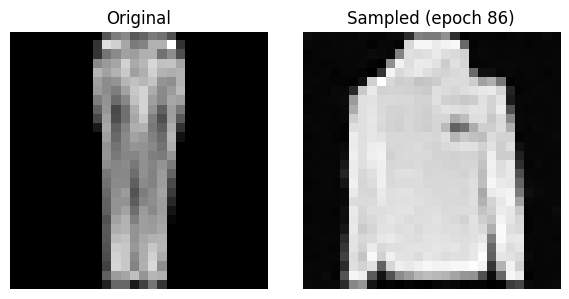

Epoch 91/100: 100%|██████████| 188/188 [00:20<00:00,  8.99it/s, loss=0.0466]


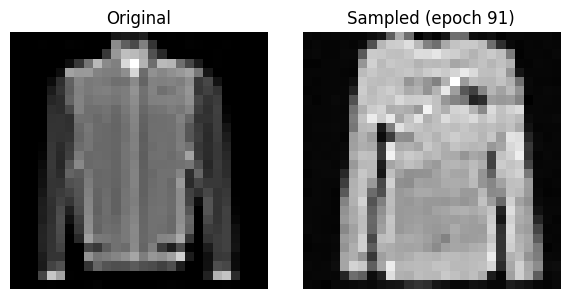

Epoch 96/100: 100%|██████████| 188/188 [00:20<00:00,  9.06it/s, loss=0.0398]


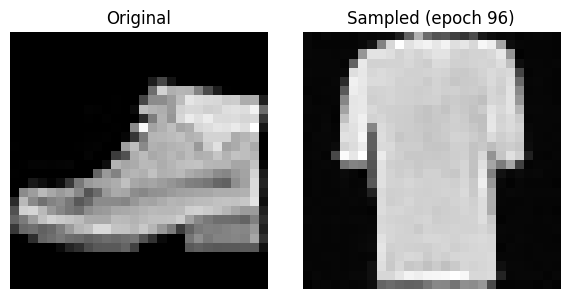

Epoch 100/100: 100%|██████████| 188/188 [00:20<00:00,  9.08it/s, loss=0.0362]


In [34]:
n_epochs = 100
image_size = 28
betas = cosine_beta_schedule(T).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)
add_reconstruction_loss = True
lambda_recon = 0.1 

# --- Training ---
for epoch in range(n_epochs):
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epochs}")
    for x0, _ in pbar:
        x0 = x0.to(device)

        # Sample t randomly for each image
        t = torch.randint(0, T, (x0.size(0),), device=device).long()

        # Forward diffusion (get x_t and noise)
        x_noisy, noise = q_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)

        # Predict the noise
        noise_pred = model(x_noisy, t.float() / T)  # Normalize t to [0,1]

        # MSE loss between predicted and true noise
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

                # Optional reconstruction loss
        """  if add_reconstruction_loss:
            with torch.no_grad():  # Don't backprop through full denoising
                reconstructed_sample = p_sample_loop(model, x_noisy, t, betas)
            recon_loss = torch.nn.functional.mse_loss(reconstructed_sample, x0)
            loss += lambda_recon * recon_loss"""


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

    # Optional sampling at end of epoch
    if epoch % 5 == 0 :
        with torch.no_grad():
            sampled = sample_ddpm(model, image_size, betas, T, device)  # (B, C, H, W)
            sampled_img = sampled[0].squeeze().cpu().numpy()            # First sample
        
            original_img = x0[0].squeeze().cpu().numpy()                # First original from current batch
        
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        
            axes[0].imshow(original_img, cmap='gray')
            axes[0].set_title('Original')
            axes[0].axis('off')
        
            axes[1].imshow(sampled_img, cmap='gray')
            axes[1].set_title(f'Sampled (epoch {epoch+1})')
            axes[1].axis('off')
        
            plt.tight_layout()
            plt.show()
